In [8]:
import os
import cv2
import numpy as np
from IPython.display import clear_output
from matplotlib.pyplot import imshow, plot, show
from keras.layers import Conv2D, Add, BatchNormalization, Input, Lambda, Multiply
from keras.backend import tensorflow_backend as K
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.losses import mean_squared_error
import tensorflow as tf
tf.__version__

'1.4.0'

##### Please set img_dir to your pictures folder first

In [33]:
res_scale = 0.1
scale = 2
batch_size = 20
validation_size = int(0.25 * batch_size)
input_shape = (128, 128, 3)
output_shape = (256, 256, 3)
# img_dir = 'DIV2K_train_HR/'
img_dir = 'VOCdevkit/VOC2012/JPEGImages/'
image_list = os.listdir(img_dir)

In [4]:
def get_data(current_batch = 0):
    
    start = current_batch * batch_size
    end = (current_batch+1) * batch_size
    train_y = [cv2.imread(os.path.join(img_dir, i), 1) for i in image_list[start:end]]
    test_x = [cv2.resize(i, input_shape[:2]) for i in train_y[-validation_size:]]
    test_y = [cv2.resize(i, output_shape[:2]) for i in train_y[-validation_size:]]
    train_x = [cv2.resize(i, input_shape[:2]) for i in train_y[:-validation_size]]
    train_y = [cv2.resize(i, output_shape[:2]) for i in train_y[:-validation_size]]
#     print(len(train_x))
#     print(len(train_y))
    
    return np.array(train_x), np.array(train_y), np.array(test_x), np.array(test_y)

### 1st implementaion of Pixel Shuffle

In [4]:
"""
Borrowed from https://github.com/tetrachrome/subpixel
Used for subpixel phase shifting after deconv operations
"""
def _phase_shift(I, r):
    bsize, a, b, c = I.get_shape().as_list()
    bsize = Lambda( lambda tensor: tf.shape(tensor)[0])(I) # Handling Dimension(None) type for undefined batch dim
    X = Lambda( lambda tensor: tf.reshape(tensor, (bsize, a, b, r, r)))(I)
    X = Lambda( lambda tensor: tf.transpose(tensor, (0, 1, 2, 4, 3)))(X)  # bsize, a, b, 1, 1
    X = Lambda( lambda tensor: tf.split(tensor, a, 1))(X) #K.split(X, a, 1)  # a, [bsize, b, r, r]
    X = Lambda( lambda tensor: tf.concat([tf.squeeze(x, axis=1) for x in tensor],2))(X)  # bsize, b, a*r, r
    X = Lambda( lambda tensor: tf.split(tensor, b, 1))(X) #K.split(X, b, 1)  # b, [bsize, a*r, r]
    X = Lambda( lambda tensor: tf.concat([tf.squeeze(x, axis=1) for x in tensor],2))(X)  # bsize, a*r, b*r
    return Lambda(lambda tensor: tf.reshape(tensor, (bsize, a*r, b*r, 1)))(X)

In [2]:
"""
Borrowed from https://github.com/tetrachrome/subpixel
Used for subpixel phase shifting after deconv operations
"""
def PS(X, r, color=False):
    if color:
        Xc = Lambda( lambda tensor: tf.split(tensor, 3, 3))(X)
        X = Lambda( lambda tensor: tf.concat([_phase_shift(x, r) for x in tensor],3))(Xc)
    else:
        X = _phase_shift(X, r)
    return X

### 2nd implementaion of Pixel Shuffle

In [5]:
def SubpixelConv2D(input_shape, scale=4):
    """
    Borrowed from https://github.com/twairball/keras-subpixel-conv/blob/master/subpixel.py
    Keras layer to do subpixel convolution.
    NOTE: Tensorflow backend only. Uses tf.depth_to_space
    Ref:
        [1] Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network
            Shi et Al.
            https://arxiv.org/abs/1609.05158
    :param input_shape: tensor shape, (batch, height, width, channel)
    :param scale: upsampling scale. Default=4
    :return:
    """
    # upsample using depth_to_space
    def subpixel_shape(input_shape):
        dims = [input_shape[0],
                input_shape[1] * scale,
                input_shape[2] * scale,
                int(input_shape[3] / (scale ** 2))]
        output_shape = tuple(dims)
        return output_shape

    def subpixel(x):
        return tf.depth_to_space(x, scale)


    return Lambda(subpixel, output_shape=subpixel_shape, name='subpixel')

### Transformation Model
just a few conv layers as res blocks and pixel shuffling

In [6]:
def transformation_model(input_shape):
    
    inputs = Input(shape = input_shape)
    conv_1 = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu', name = 'conv_1_1')(inputs)
    
    ## Just for using in the for loop
    X = conv_1
    
    ## Res Blocks
    for i in range(2, 10):
        X = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu', name = 'conv_{}_1'.format(i))(X)
        X1 = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', name = 'conv_{}_2'.format(i))(X)
        X1 = Lambda( lambda tensor: tensor * res_scale, name = 'multiply_{}'.format(i))(X1)
        X = Add()([X, X1])
    
    ## Adding result of Res Blocks with output of 1st layer
    X = Add()([X, conv_1])
    
    ## This portion is for upsampling, keeping r = 2
    X = Conv2D(64, (3, 3), strides = (1, 1), padding = 'same', activation = 'relu', name = 'conv_10_1')(X)
    
    ## 1st implementation of Pixel Shuffle
    X = Conv2D(3*(scale ** 2), (3, 3), strides = (1, 1), padding = 'same', activation = 'relu', name = 'conv_11_1')(X)
    X = PS(X, scale, color = True)

    ## 2nd implementaion of Pixel Shuffle
#     X = Conv2D(64 * (scale ** 2), (3, 3), strides = (1, 1), padding = 'same', activation = 'relu', name = 'conv_11_1')(X)
#     X = SubpixelConv2D(X.shape, scale = scale)(X)
    
    ## Just because Jeremy Howard said it works
    X = BatchNormalization()(X)
    
    ## One final conv layer, to bring back to required size
    X = Conv2D(3, (3, 3), strides = (1, 1), padding = 'same', name = 'conv_12_1')(X)
    
    model = Model(inputs = inputs, outputs = X)
    
    return model

### Loss Model
loading up vgg16 from keras.applications and sending some its layers as output  

In [7]:
def loss_model():
    
    base_model = VGG16(include_top = False, weights = 'imagenet', input_shape = output_shape)
#     vgg.load_model('pre_trained/vgg16_weights_tf_dim_ordering_tf_kernels.h5')

    ## listing all the layers required for perceptual loss as mentioned in EDSR
    layers_required = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
    
    for layer in base_model.layers:
        layer.trainable = False
    
    model = Model(inputs = base_model.input, outputs = [base_model.get_layer(i).output for i in layers_required])
    return model

### Full Model
combining the transformation model and loss model into a single one, and using MSE loss between output of loss model om generated and actual images

In [15]:
def full_model():
    l_model = loss_model()
    t_model = transformation_model(input_shape)
    loss_model_outputs = l_model(t_model.output)
    model = Model(inputs = t_model.input, outputs = loss_model_outputs)
    return model

In [16]:
model = full_model()
model.compile(optimizer = 'adam', loss = 'mse', metrics = ['accuracy'])

### Training Loop
Caliing fit funtion iteratively for all the batches because I can't load up all the images at once in main memory or gpu memory

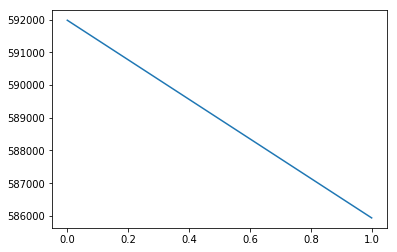




 ******************** 



current batch number:  1 out of  85


In [ ]:
num_batches = len(image_list) // batch_size
l_model = loss_model()

for i in range(num_batches):
    print('\n\n\n', '*'*20, '\n\n\n')
    print('current batch number: ', i, 'out of ', num_batches)
    train_x, train_y, test_x, test_y = get_data(i)
    loss_train_y = l_model.predict(train_y)
    loss_test_y = l_model.predict(test_y)
    model.fit(x = train_x, y = loss_train_y, batch_size = 16, epochs = 200, validation_data = (test_x, loss_test_y))
    
    ## This code is just to plot the losses, you may comment all this and un-comment the above model.fit() call
#     history = model.fit(x = train_x, y = loss_train_y, batch_size = 16, epochs = 200, verbose = 0, validation_data = (test_x, loss_test_y))
#     clear_output()
#     plot(history.history['loss'])
#     show()

### This is the end of useful code
### below is just some code snippets left from experimentations

In [ ]:
np.array(loss[3]).shape

In [ ]:
train_x, train_y, test_x, test_y = get_data(0)
print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

In [ ]:
def perceptual_loss(y_true, y_pred):
    l_model = loss_model(y_true)
    actual = l_model.predict(y_true)
    l_model = loss_model(y_pred)
    generated = l_model.predict(y_pred)
    mse_loss = mean_squared_error(actual, generated)
    return mse_loss

In [ ]:
l_model = loss_model()
l_model.summary()

In [ ]:
t_model = transformation_model(input_shape)
t_model.summary()

In [ ]:
model.summary()